A collection of scripts to visualise the results for stationary bandits. More details on the algorithms can be found at [Stationary Bandits](stationary_bandits_comparison.ipynb).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict
from jupyterthemes import jtplot

sns.set(style="ticks", context="talk", color_codes=True)
jtplot.style(ticks=True, grid=False)
plt.rcParams.update({
    'axes.spines.right': False, 
    'axes.spines.top': False, 
    'lines.linewidth': 2., 
    'axes.xmargin': 0.01, 
    'savefig.dpi': 300,
})

%matplotlib inline

Before we compare the active inference algorithm with Thompson sampling and the UCB algorithm, we will illustrate how the values of action precision $\gamma$ and the precision of prior preferences $\lambda$ impact cumulative regret of the active inference agent, as a function of arm number $K$ and difficulty $\epsilon$. Bellow we show the expected regret rate $bar{R}(T)$ after $T=10^4$ trials. We define the regret rate as the trial and ensamble average of the cumulative regret. Hence,

$$\tilde{R}_T = \frac{1}{T} E[R(T)] = \frac{1}{N \cdot T} \sum_{n=1}^N \sum_{t=1}^T \left[p_{max} - p_{a_t^n}\right],$$

where $p_{a_t^n}$ denotes the probability associated with the arm that was selected on the $t$th trial and the $n$th sample. Note that $p_{max} = \frac{1}{2} + \epsilon$ and that in the case of stationary bandits the optimal arm does not change. Hence, we can fix the optimal arm to choice $a_t^n=1$. Hence we can rewrite the above expression as 

$$ \tilde{R}_T = \epsilon \left(1 - p(a^*) \right), \qquad p(a^*) = \frac{1}{N \cdot T}\sum_{n=1}^N \sum_{t=1}^T \delta_{a_t^n, 1}.$$

For example, in the case of random choices with unifrom probability over arms we get the following regret rate

$$ \tilde{R}_T = \epsilon \frac{K-1}{K} $$

we will use this as a regerence line on the following plots. 

In [30]:
def multi_plots(regrets, eps, Ks):
    fig, axes = plt.subplots(len(eps), len(Ks), sharey='row', sharex=True, figsize=(15, 10))
    colors = ['b', 'r']
    lstyle = [':', '-.', '-' ]
    labels = ['G-AI', 'A-AI']
    lambdas =  np.arange(0, 1.5, .015)
    for i, ϵ in enumerate(eps):
        for j, K in enumerate(Ks):
            for an, algo_name in enumerate(['SUP', 'APP']):
                for t, T in enumerate([100, 1000, 10**5]):
                    if t == 2:
                        axes[i, j].plot(lambdas, regrets[algo_name][ϵ][K][:, t]/T, lw=3, color=colors[an], linestyle=lstyle[t], label=labels[an])
                    else:
                        axes[i, j].plot(lambdas, regrets[algo_name][ϵ][K][:, t]/T, lw=3, color=colors[an], linestyle=lstyle[t])
                    
#                 print(K, ϵ,  algo_name, np.min(regrets[algo_name][ϵ][K]/10000), np.argmin(regrets[algo_name][ϵ][K]/10000))
            axes[i, j].hlines(ϵ/100 * (K - 1)/K, lambdas[0], lambdas[-1], 'k', linestyle='--', lw=2, label='RC')
            if i == 0:
                axes[i, j].set_title(r'$K={}$'.format(K))
            if i == len(eps) - 1:
                axes[i, j].set_xlabel(r'$\lambda$')
#                 plt.setp(axes[i, j], 
#                          xticks=[0.5, 4.5, 8.5, 12.5, 16.5],
#                          xticklabels=(10.*lambdas).astype(np.int16)[::4]/10.)

        axes[i, 0].set_ylabel(r'$\tilde{R}_T$');
        
        axes[i, -1].text(1., .4, r'$\epsilon={}$'.format(ϵ/100), rotation=-90, transform=axes[i,-1].transAxes, fontsize=16)
    axes[0, -1].legend(loc=4)
    axes[0, 0].annotate(r"$T=10^2$", xy=(0.5, 0.08), xycoords='data', xytext=(0.9, 0.105), textcoords='data',
                        arrowprops=dict(facecolor='black',shrink=.01,alpha=.2), horizontalalignment='right', verticalalignment='top')
    axes[0, 0].annotate(r"$T=10^3$", xy=(0.15, 0.05), xycoords='data', xytext=(.5, 0.075), textcoords='data',
                        arrowprops=dict(facecolor='black',shrink=.01,alpha=.2), horizontalalignment='right', verticalalignment='top')
    axes[0, 0].annotate(r"$T=10^5$", xy=(0.3, 0.035), xycoords='data', xytext=(.8, 0.035), textcoords='data',
                        arrowprops=dict(facecolor='black',shrink=.01,alpha=.2), horizontalalignment='right', verticalalignment='top')
        
    return fig

In [13]:
Ks = [5, 10, 20, 40, 80]
cum_reg = defaultdict(lambda: {})
for ϵ in [10, 25, 40]:
    tmp = np.load('res_AI_Ks_e{}.npz'.format(ϵ), allow_pickle=True)
    for name in ['SUP', 'APP']:
        cum_reg[name][ϵ] = {}
        for K in Ks:
            cum_reg[name][ϵ][K] = tmp[name + '_K{}'.format(K)].item()['regret'].mean(-1)[..., [0, 9, 999]]

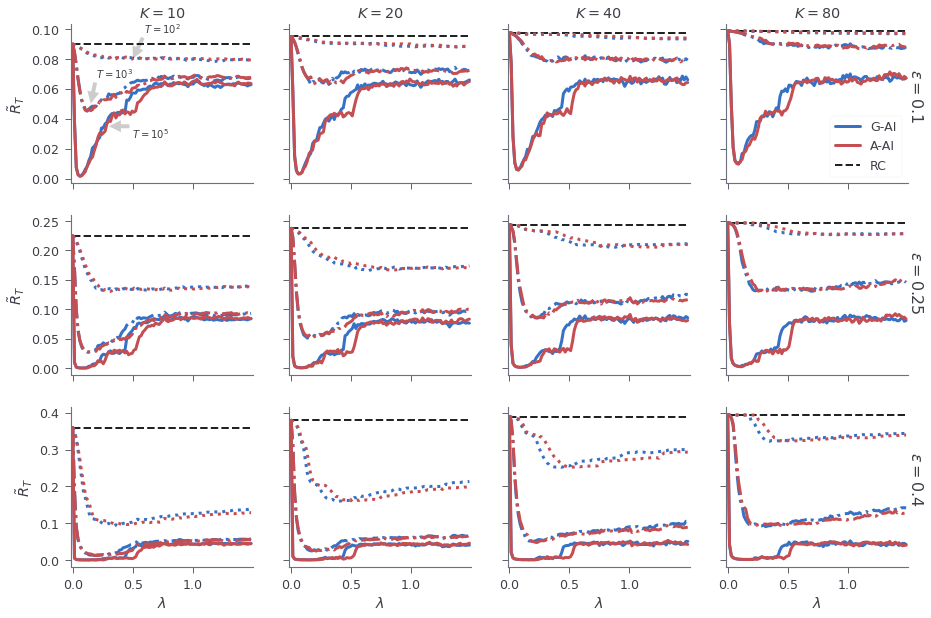

In [31]:
fig = multi_plots(cum_reg, [10, 25, 40], [10, 20, 40, 80])
fig.savefig('Fig1.pdf', transparent=True, bbox_inches='tight', dpi=300)

In what follows we will compare the active inference based agent ($\textrm{AI}_{\textrm{APP}}$) with agents using the Bayesian upper confidence bound (UCB) and the optimistic Thomspon sampling (OTS) as action selection algorithms. We will first consider the depenence of the cumulative regret over the course of experiment on the number of arms $K$ and difficulty $\epsilon$.

In [100]:
Ks = [10, 20, 40, 80]
reg_summ = defaultdict(lambda: {})
epist_summ = defaultdict(lambda: {})
for ϵ in [10, 25, 40]:
    tmp = np.load('res_RL_Ks_e{}.npz'.format(ϵ), allow_pickle=True)
    for name in ['OTS']:
        epist_summ[name][ϵ] = {}
        reg_summ[name][ϵ] = {}
        for K in Ks:
            reg_summ[name][ϵ][K] = tmp[name + '_K{}'.format(K)].item()['regret']
            epist_summ[name][ϵ][K] = tmp[name + '_K{}'.format(K)].item()['epistemic']
    
    tmp = np.load('res_BUCB_Ks_e{}.npz'.format(ϵ), allow_pickle=True)
    reg_summ['BUCB'][ϵ] = {}
    epist_summ['BUCB'][ϵ] = {}
    for K in Ks:
        reg_summ['BUCB'][ϵ][K] = tmp['BUCB_K{}'.format(K)].item()['regret']
        epist_summ['BUCB'][ϵ][K] = tmp['BUCB' + '_K{}'.format(K)].item()['epistemic']
    
    tmp = np.load('res_AI_Ks_e{}.npz'.format(ϵ), allow_pickle=True)
    λ = 6 # sets \lambda = 0.1
    for name in ['APP']:
        epist_summ[name][ϵ] = {}
        reg_summ[name][ϵ] = {}
        for K in Ks:
            reg_summ[name][ϵ][K] = tmp[name + '_K{}'.format(K)].item()['regret'][λ]
            epist_summ[name][ϵ][K] = tmp[name + '_K{}'.format(K)].item()['epistemic'][λ]

In [109]:
from scipy.stats import t
def multi_plots(regrets, eps, Ks):
    N = 1000
    t_bounds = t.interval(0.95, N - 1)
    fig, axes = plt.subplots(len(eps), len(Ks), sharex=True, figsize=(20, 10))
    colors = ['g', 'm', 'r']
    lstyle = [':', '-.', '-' ]
    labels = ['B-UCB', 'O-TS', 'A-AI']
    times = np.arange(100, 10**5 + 100, 100)
    for i, ϵ in enumerate(eps):
        for j, K in enumerate(Ks):
            for an, algo_name in enumerate(['BUCB', 'OTS', 'APP']):
                mu = reg_summ[algo_name][ϵ][K].mean(-1)
                std = reg_summ[algo_name][ϵ][K].std(-1, ddof=1)
        
                ci = [mu + critval * std/np.sqrt(N) for critval in t_bounds]
        
                axes[i, j].fill_between(times, ci[1], y2=ci[0], color=colors[n], alpha=.2)
                axes[i, j].semilogx(times, mu, lw=3, color=colors[an], label=labels[an])
                    
            axes[i, j].semilogx(times, np.log(times) * ϵ * (K - 1)/(100 * np.log(1 + 4 *(ϵ/100)**2)/2), 'k:', label=r'$\omega(\epsilon, K) \cdot \ln t$')
            if i == 0:
                axes[i, j].set_title(r'$K={}$'.format(K))
            if i == len(eps) - 1:
                axes[i, j].set_xlabel(r'$t$')

        axes[i, 0].set_ylabel(r'$R_T$');
        
        axes[i, -1].text(1., .4, r'$\epsilon={}$'.format(ϵ/100), rotation=-90, transform=axes[i,-1].transAxes, fontsize=16)
    axes[0, 0].legend()
    axes[0, 0].set_xlim([100, 10**5])
    
    return fig

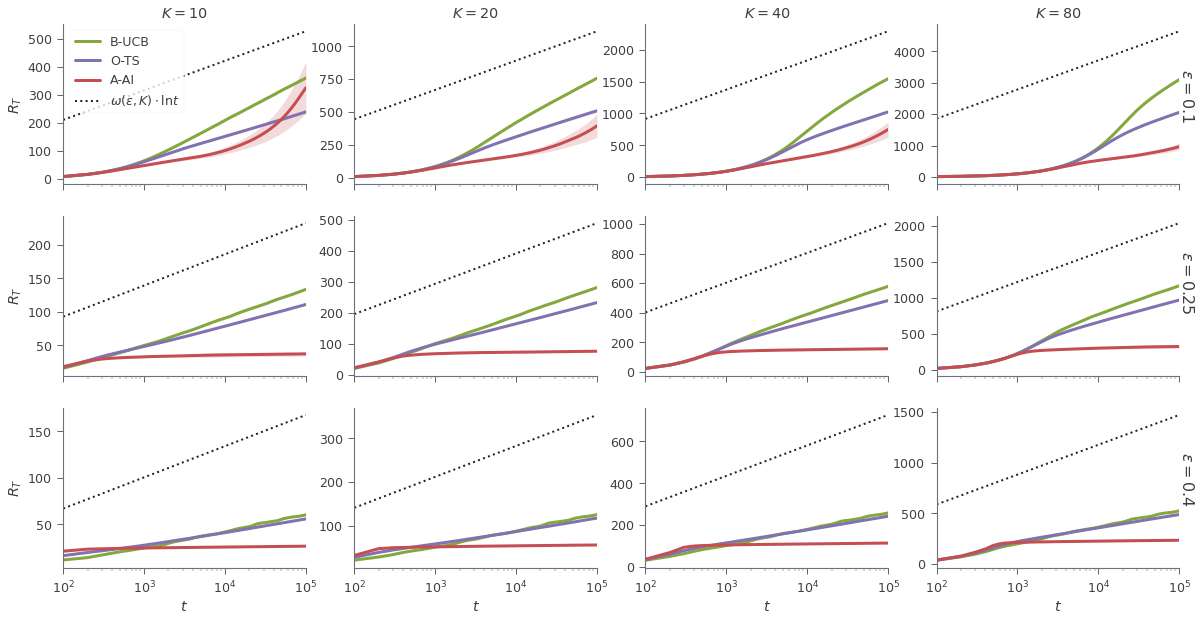

In [110]:
fig = multi_plots(reg_summ, [10, 25, 40], [10, 20, 40, 80])
fig.savefig('Fig2.pdf', transparent=True, bbox_inches='tight', dpi=300)

In [102]:
def multi_plots_epistemics(regrets, eps, Ks):
    fig, axes = plt.subplots(len(eps), len(Ks), sharey='row', sharex=True, figsize=(15, 10))
    colors = ['g', 'm', 'r']
    lstyle = [':', '-.', '-' ]
    labels = ['B-UCB', 'O-TS', 'A-AI']
    times = np.arange(1, 10**4, 10)
    for i, ϵ in enumerate(eps):
        for j, K in enumerate(Ks):
            for an, algo_name in enumerate(['BUCB', 'OTS', 'APP']):
                tms = np.arange(100, 10**5 + 100, 100)
                axes[i, j].semilogx(tms, regrets[algo_name][ϵ][K].mean(-1)/tms, lw=3, color=colors[an], label=labels[an]) 
                    
            if i == 0:
                axes[i, j].set_title(r'$K={}$'.format(K))
            if i == len(eps) - 1:
                axes[i, j].set_xlabel(r'$t$')
#                 plt.setp(axes[i, j], 
#                          xticks=[0.5, 4.5, 8.5, 12.5, 16.5],
#                          xticklabels=(10.*lambdas).astype(np.int16)[::4]/10.)

        axes[i, 0].set_ylabel(r'$\tilde{E}_T$');
        
        axes[i, -1].text(1., .4, r'$\epsilon={}$'.format(ϵ/100), rotation=-90, transform=axes[i,-1].transAxes, fontsize=16)
    axes[0, 0].legend()
    axes[0, 0].set_xlim([100, 10**5])
    
    return fig

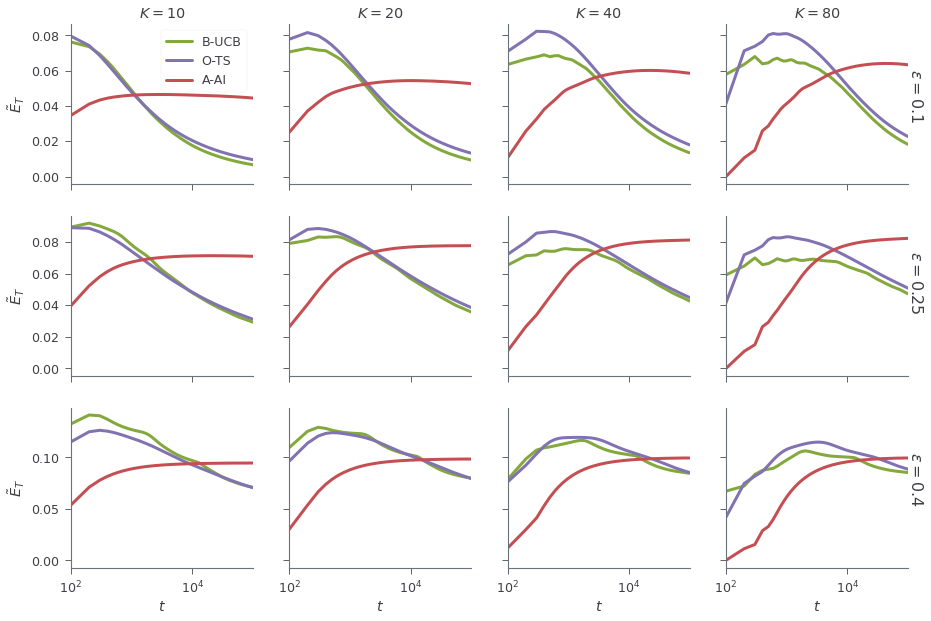

In [103]:
fig = multi_plots_epistemics(epist_summ, [10, 25, 40], [10, 20, 40, 80])


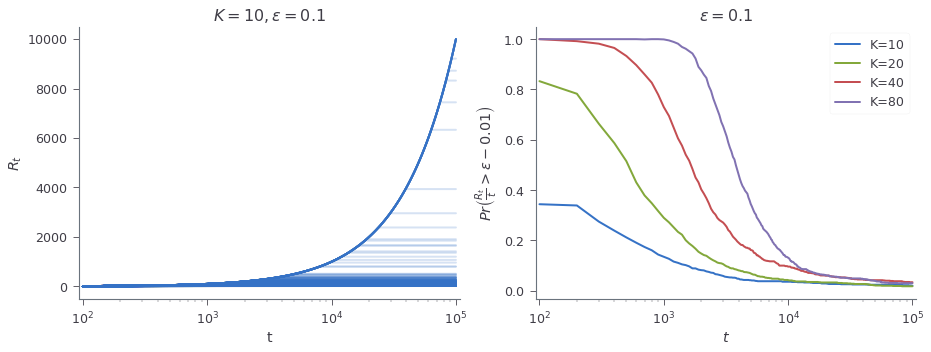

In [154]:
K = 10
eps = 10
trials = np.arange(100, 10**5+100, 100)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
axes[0].semilogx(trials, reg_summ['APP'][eps][K], 'b', alpha=.2);
axes[0].set_ylabel(r'$R_t$');
axes[0].set_xlabel(r't');
axes[0].set_title(r'$K={}, \epsilon={}$'.format(K, eps/100), fontsize=16);
for K in [10, 20, 40, 80]:
    axes[1].semilogx(trials, (reg_summ['APP'][eps][K]/trials[:, None] > eps/100 - 0.01).sum(-1)/1000, lw=2, label=r'K={}'.format(K));

axes[1].legend()
axes[1].set_ylabel(r'$Pr\left(\frac{R_t}{t} > \epsilon-0.01\right)$');
axes[1].set_xlabel(r'$t$');
axes[1].set_title(r'$\epsilon={}$'.format(eps/100), fontsize=16);

fig.savefig('example.png')